In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from definitions import data_source_path, target_countries, fig_size, \
show_plots, save_figs, show_results, target_var, country_col, date_col, incl_countries, incl_years, fake_num
from helper_functions_general import read_data, get_impl_date, get_trans, get_timescale, get_data_path, get_fig_path, get_table_path
from plot_functions import plot_corr

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller

In [2]:
country_name_formal = {'switzerland': 'Switzerland',
                      'ireland': 'Ireland',
                      'united_kingdom': 'United Kingdom',
                      'france': 'France',
                      'portugal': 'Portugal'}

var_name_formal = {'co2': 'CO2 Emissions',
                   'co2_cap': 'CO2 Emissions per capita',
                   'gdp': 'GDP',
                   'gdp_cap': 'GDP per capita',
                   'ind_prod': 'Industrial Production',
                   'pop': 'Population',
                   'infl': 'Inflation',
                   'brent': 'Brent Oil'
                   }

# Descriptive data

In [3]:
var_name = 'brent'
timeframe = 'm'

series = read_data(get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}')
series

series = series[[country_col, date_col, var_name]]
series = series.replace({fake_num:np.nan})

print(series.groupby(country_col)[var_name].std().mean())
print(sum(series[var_name].isna()))
print(sum(series[var_name]==fake_num))

series.describe()

30.098833179578843
0
0


,brent
count,4522.000000
mean,64.547689
std,30.038855
min,18.710000
25%,39.600000
50%,61.720000
75%,84.820000
max,132.720000


In [4]:
co2_m = read_data(get_data_path(timeframe='m'), file_name='co2_m')
co2_q = read_data(get_data_path(timeframe='q'), file_name='co2_q')

co2_m.describe()

,year,month,co2
count,4560.000000,4560.000000,4.560000e+03
mean,2009.500000,6.500000,1.649718e+10
std,5.766914,3.452431,1.939575e+10
min,2000.000000,1.000000,9.265613e+08
25%,2004.750000,3.750000,4.359616e+09
50%,2009.500000,6.500000,7.941463e+09
75%,2014.250000,9.250000,2.543950e+10
max,2019.000000,12.000000,1.097771e+11


In [5]:
gdp_q = read_data(get_data_path(timeframe='q'), file_name='gdp_q')
gdp_m = read_data(get_data_path(timeframe='m'), file_name='gdp_m')

gdp_q.describe()

,year,quarter,gdp
count,1520.000000,1520.000000,1.520000e+03
mean,2009.500000,2.500000,8.149040e+11
std,5.768179,1.118402,9.872702e+11
min,2000.000000,1.000000,2.863720e+10
25%,2004.750000,1.750000,1.744602e+11
50%,2009.500000,2.500000,3.323868e+11
75%,2014.250000,3.250000,1.150819e+12
max,2019.000000,4.000000,4.848486e+12


In [6]:
ind_prod_m = read_data(get_data_path(timeframe='m'), file_name='ind_prod_m')
ind_prod_q = read_data(get_data_path(timeframe='q'), file_name='ind_prod_q')

ind_prod_m.describe()

,year,month,ind_prod
count,4560.000000,4560.000000,4560.000000
mean,2009.500000,6.500000,0.020187
std,5.766914,3.452431,0.066786
min,2000.000000,1.000000,-0.282000
25%,2004.750000,3.750000,-0.009000
50%,2009.500000,6.500000,0.019000
75%,2014.250000,9.250000,0.050000
max,2019.000000,12.000000,0.597000


In [7]:
infl_m = read_data(get_data_path(timeframe='m'), file_name='infl_m')
infl_q = read_data(get_data_path(timeframe='q'), file_name='infl_q')

infl_m.describe()

,year,month,infl
count,4800.000000,4800.000000,4800.000000
mean,2009.500000,6.500000,0.022253
std,5.766882,3.452412,0.020997
min,2000.000000,1.000000,-0.043000
25%,2004.750000,3.750000,0.010000
50%,2009.500000,6.500000,0.020000
75%,2014.250000,9.250000,0.031000
max,2019.000000,12.000000,0.177000


In [8]:
brent_m = read_data(get_data_path(timeframe='m'), file_name='brent_m')
brent_q = read_data(get_data_path(timeframe='q'), file_name='brent_q')

brent_m.describe()

,year,month,brent
count,240.000000,240.000000,240.000000
mean,2009.500000,6.500000,64.553625
std,5.778332,3.459267,29.973289
min,2000.000000,1.000000,18.710000
25%,2004.750000,3.750000,39.862500
50%,2009.500000,6.500000,62.005000
75%,2014.250000,9.250000,83.207500
max,2019.000000,12.000000,132.720000


In [9]:
pop_q = read_data(get_data_path(timeframe='q'), file_name='pop_q')
pop_m = read_data(get_data_path(timeframe='m'), file_name='pop_m')

pop_q.describe()

,year,quarter,pop
count,1520.000000,1520.000000,1.520000e+03
mean,2009.500000,2.500000,2.334591e+07
std,5.768179,1.118402,2.452787e+07
min,2000.000000,1.000000,2.794100e+06
25%,2004.750000,1.750000,7.506125e+06
50%,2009.500000,2.500000,1.050610e+07
75%,2014.250000,3.250000,4.322110e+07
max,2019.000000,4.000000,8.314600e+07


# Total

In [10]:
timeframe = 'm'
df = read_data(source_path=get_data_path(timeframe=timeframe), file_name=f'total_{timeframe}')
df = df.replace({fake_num: np.nan})
df

,country,date,year,month,co2,gdp,ind_prod,infl,pop,brent,co2_cap,gdp_cap
0,austria,2000-01-01,2000,1,9.726928e+09,2.309478e+11,0.057,0.014,8.003000e+06,25.51,1215.410177,28857.653380
1,austria,2000-02-01,2000,2,8.532685e+09,2.321217e+11,0.107,0.019,8.004700e+06,27.78,1065.959381,28998.180236
2,austria,2000-03-01,2000,3,8.134567e+09,2.332957e+11,0.097,0.019,8.006400e+06,27.49,1016.008070,29138.647415
3,austria,2000-04-01,2000,4,6.546738e+09,2.344696e+11,0.105,0.018,8.008100e+06,22.76,817.514486,29279.054957
4,austria,2000-05-01,2000,5,5.603262e+09,2.352176e+11,0.104,0.016,8.010100e+06,27.74,699.524567,29365.122366
...,...,...,...,...,...,...,...,...,...,...,...,...
4517,united_kingdom,2019-06-01,2019,6,2.864851e+10,3.302814e+12,-0.016,NaN,6.684433e+07,64.22,428.585441,49410.534426
4518,united_kingdom,2019-07-01,2019,7,2.872032e+10,3.322513e+12,-0.014,NaN,6.686800e+07,63.92,429.507708,49687.638332
4519,united_kingdom,2019-08-01,2019,8,2.809851e+10,3.338771e+12,-0.020,NaN,6.689167e+07,59.04,420.059973,49913.108758
4520,united_kingdom,2019-09-01,2019,9,3.070698e+10,3.355029e+12,-0.017,NaN,6.691533e+07,62.83,458.892976,50138.419695


In [11]:
df[country_col].unique()

array(['austria', 'belgium', 'bulgaria', 'croatia', 'czech_republic',
       'france', 'germany', 'greece', 'hungary', 'ireland', 'italy',
       'lithuania', 'netherlands', 'portugal', 'romania', 'slovakia',
       'spain', 'switzerland', 'united_kingdom'], dtype=object)

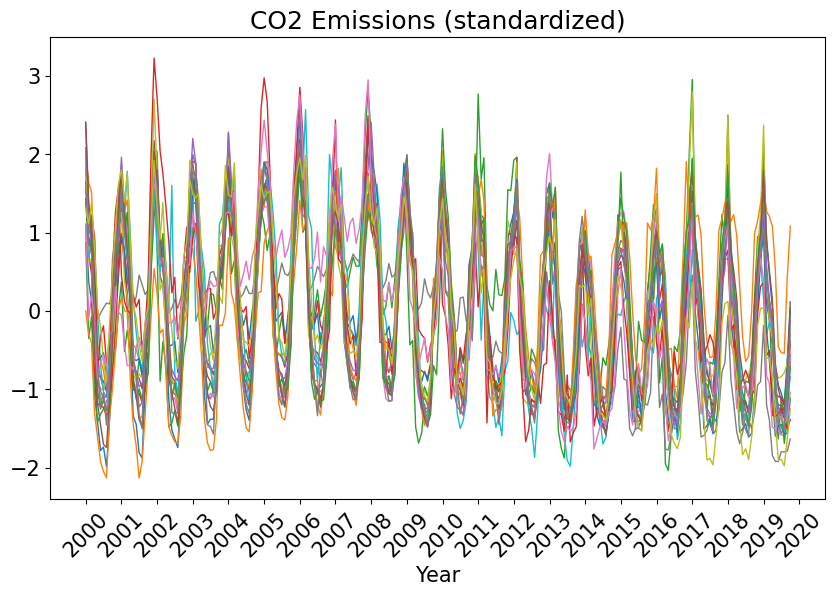

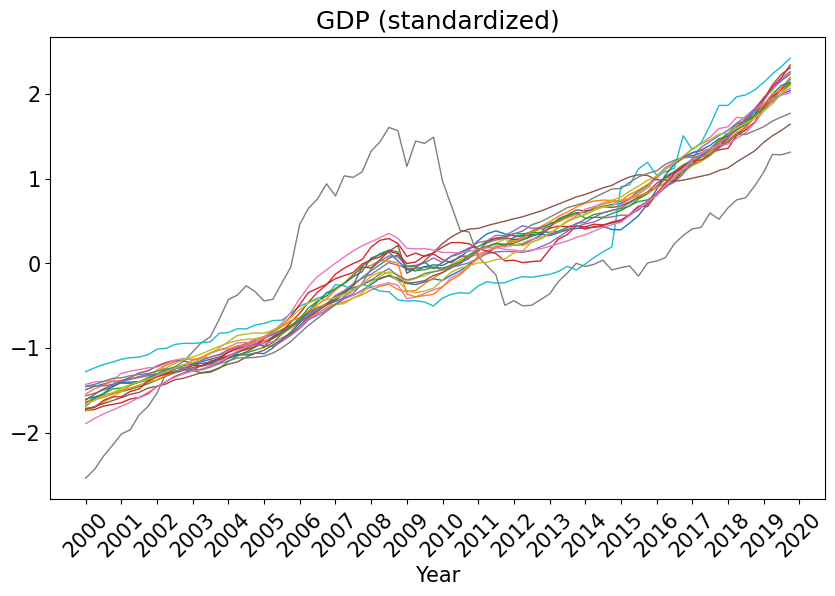

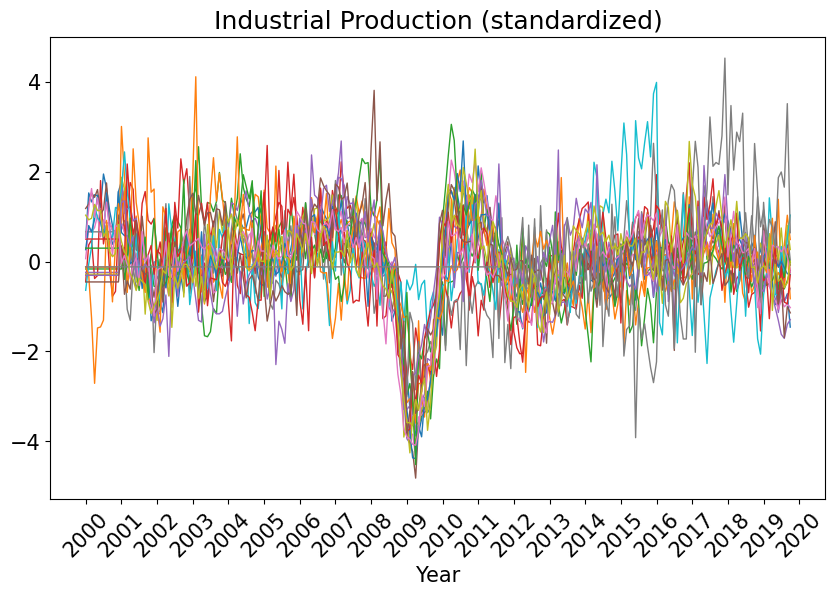

C:\Users\Bas\anaconda3\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Bas\anaconda3\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\Bas\anaconda3\lib\site-packages\sklearn\utils\extmath.py:1020: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


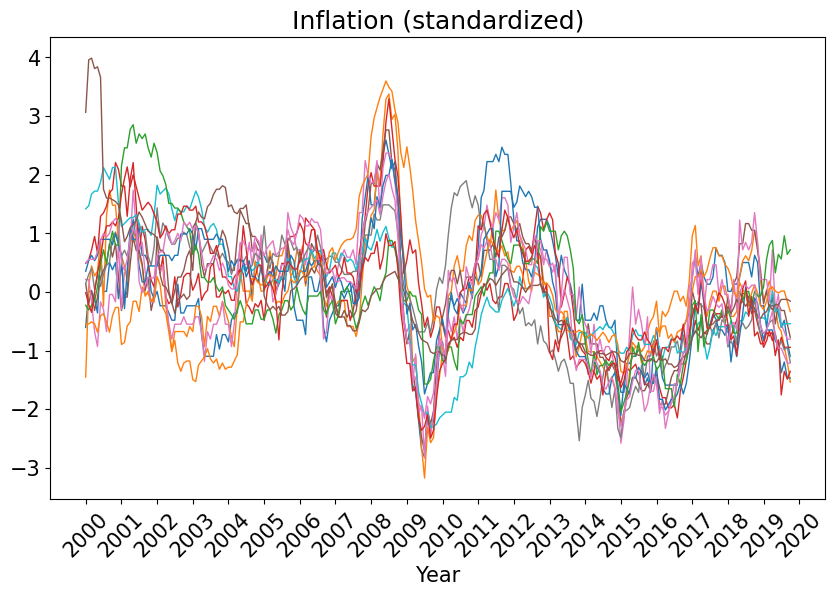

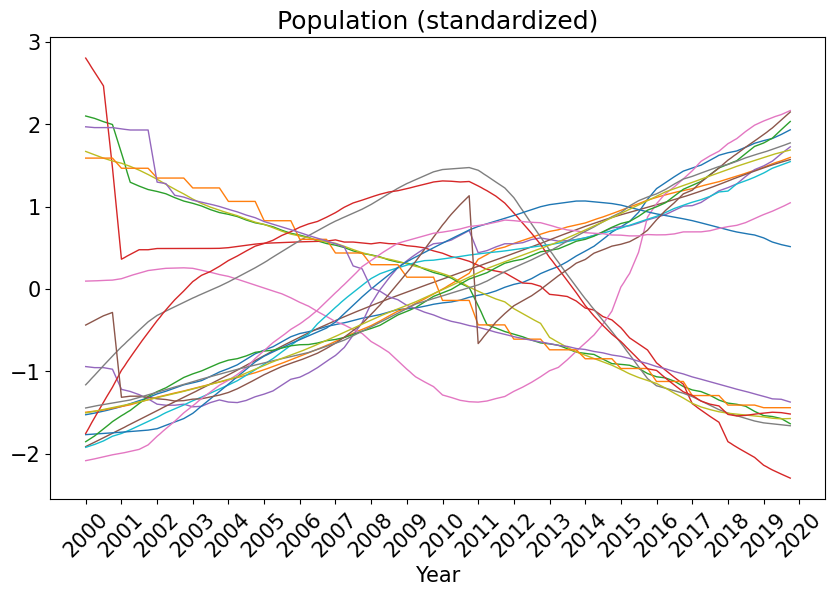

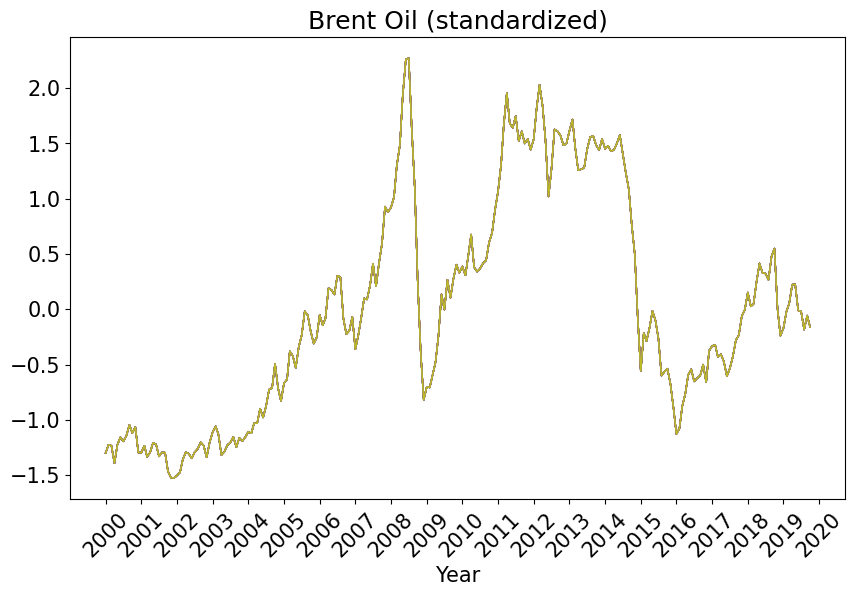

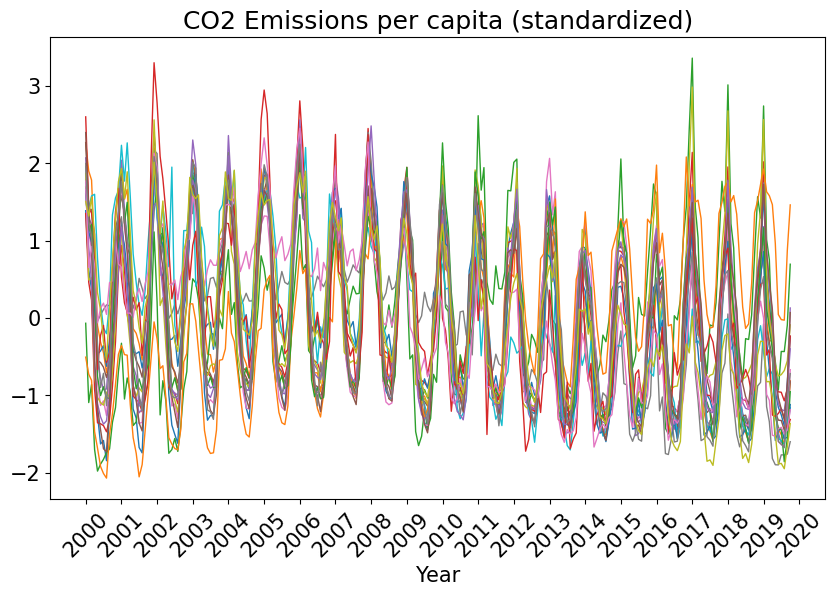

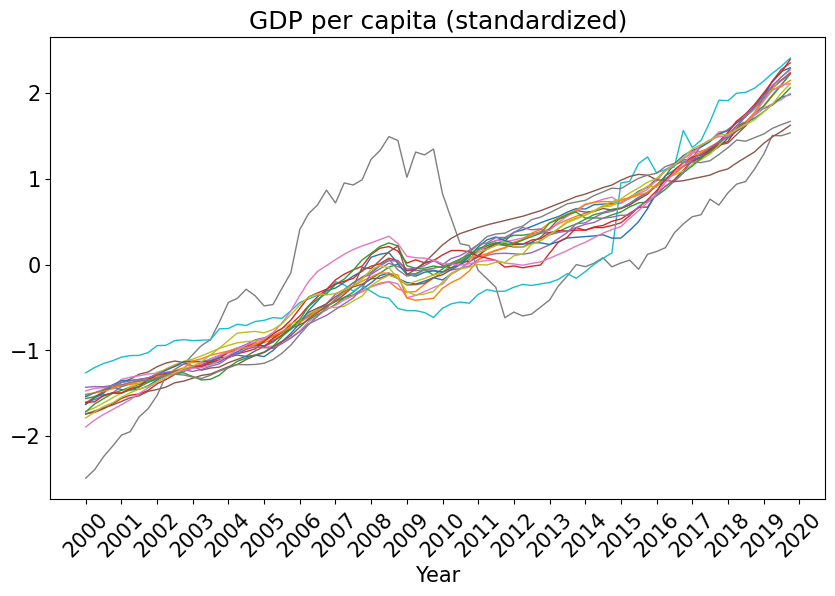

In [31]:
def all_series_stand(df: object, timeframe: str):
    timescale = get_timescale(timeframe=timeframe)
    trans = get_trans(timeframe=timeframe)

    scaler = StandardScaler()
    
    for series in trans.keys():

        df_pivot = df.pivot(index=date_col, columns=country_col, values=series)
        
        df_pivot.index = pd.to_datetime(df_pivot.index)
        df_scale = scaler.fit_transform(df_pivot)

        fig, ax = plt.subplots(figsize=fig_size)
        ax.plot(df_pivot.index, df_scale, label=df_pivot.columns, linewidth=1)

        ax.xaxis.set_major_locator(mdates.YearLocator())
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
        ax.set_title(f'{var_name_formal[series]} (standardized)')
        ax.set_xlabel('Year')
#         ax.set_ylabel(f'{series}')
#         ax.legend(loc='upper center', bbox_to_anchor=(1, 1.5),
#           ncol=4, fancybox=True, shadow=True)
    
        plt.savefig(f"stand_{series}.png", dpi=300, bbox_inches='tight')
        plt.show()
            
all_series_stand(df, timeframe=timeframe)

# Missing values

In [13]:
df.groupby('country').count()

,date,year,month,co2,gdp,ind_prod,infl,pop,brent,co2_cap,gdp_cap
country,,,,,,,,,,,
austria,238,238,238,238,238,238,238,238,238,238,238
belgium,238,238,238,238,238,238,238,238,238,238,238
bulgaria,238,238,238,238,238,238,0,238,238,238,238
croatia,238,238,238,238,238,238,238,238,238,238,238
czech_republic,238,238,238,238,238,238,0,238,238,238,238
france,238,238,238,238,238,238,238,238,238,238,238
germany,238,238,238,238,238,238,238,238,238,238,238
greece,238,238,238,238,238,238,238,238,238,238,238
hungary,238,238,238,238,238,238,0,238,238,238,238


In [14]:
2632 - df.groupby('country').count().sum(axis=1)

country
austria            14
belgium            14
bulgaria          252
croatia            14
czech_republic    252
france             14
germany            14
greece             14
hungary           252
ireland            14
italy              14
lithuania          14
netherlands        14
portugal           14
romania           252
slovakia           14
spain              14
switzerland       252
united_kingdom    252
dtype: int64

# Correlation plot

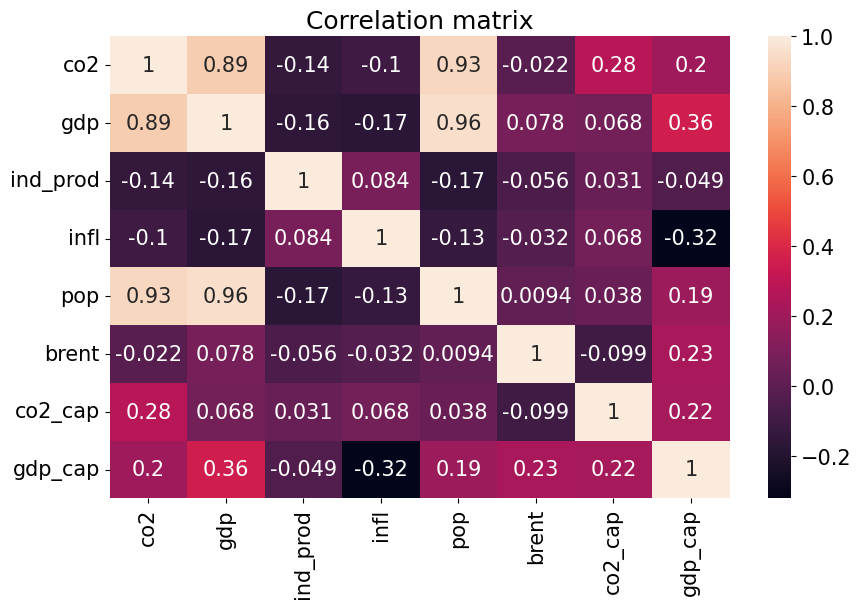

In [15]:
df_cor = df.copy()

df_cor = df_cor[get_trans()]
cor_matrix = df_cor.corr()

plt.figure(figsize=fig_size)
sns_plot = sns.heatmap(cor_matrix, annot=True)
plt.title('Correlation matrix')

sns_plot.figure.savefig("corr_matrix.png", bbox_inches='tight', dpi=300)
plt.show()

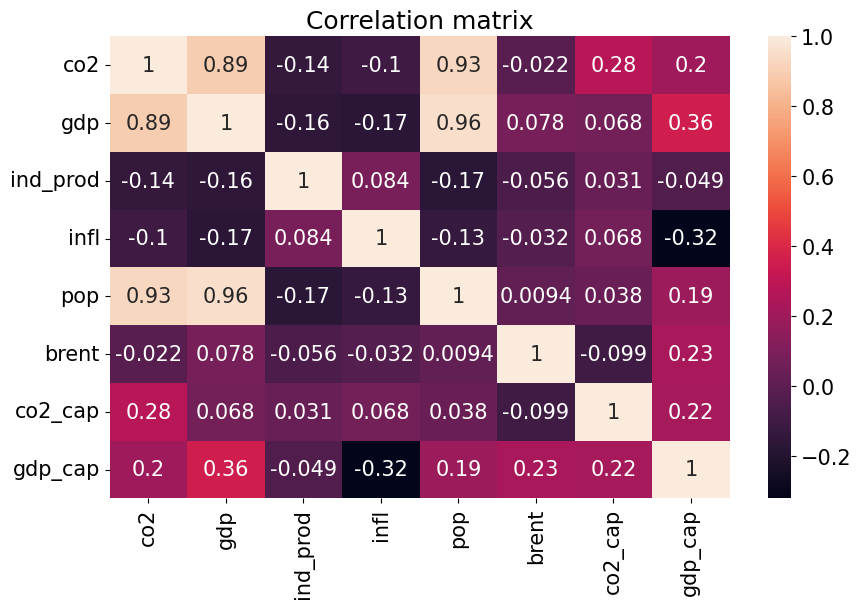

In [25]:
scaler = StandardScaler()
df_scale = df.copy()

for series in get_trans():
    df_scale[series] = scaler.fit_transform(np.array(df_scale[series]).reshape(-1, 1))

# df_scale = df_scale.columns.drop(['co2_cap', 'gdp_cap'])
df_scale

df_cor = df_scale[get_trans()]
cor_matrix = df_cor.corr()

plt.figure(figsize=fig_size)
sns_plot = sns.heatmap(cor_matrix, annot=True)
plt.title('Correlation matrix')

sns_plot.figure.savefig("corr_matrix_stand.png", bbox_inches='tight', dpi=300)
plt.show()

# CO2 emissions target counties

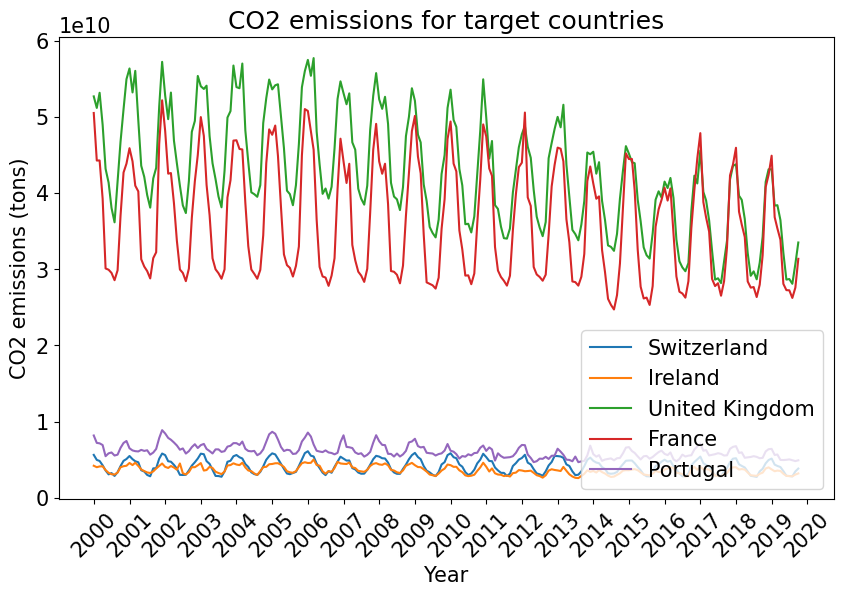

In [34]:
df_target = df[df['country'].isin(target_countries)]
df_target = df_target.set_index('date')[['country','co2']]
df_target.index = pd.to_datetime(df_target.index)

fig, ax = plt.subplots(figsize=fig_size)
for country in target_countries:
    ax.plot(df_target[df_target['country']==country]['co2'], label=country_name_formal[country])

ax.xaxis.set_major_locator(mdates.YearLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title('CO2 emissions for target countries')
ax.set_xlabel('Year')
ax.set_ylabel('CO2 emissions (tons)')
plt.legend(loc='lower right')

plt.savefig(f'co2_targets.png', dpi=300, bbox_inches='tight')
plt.show()

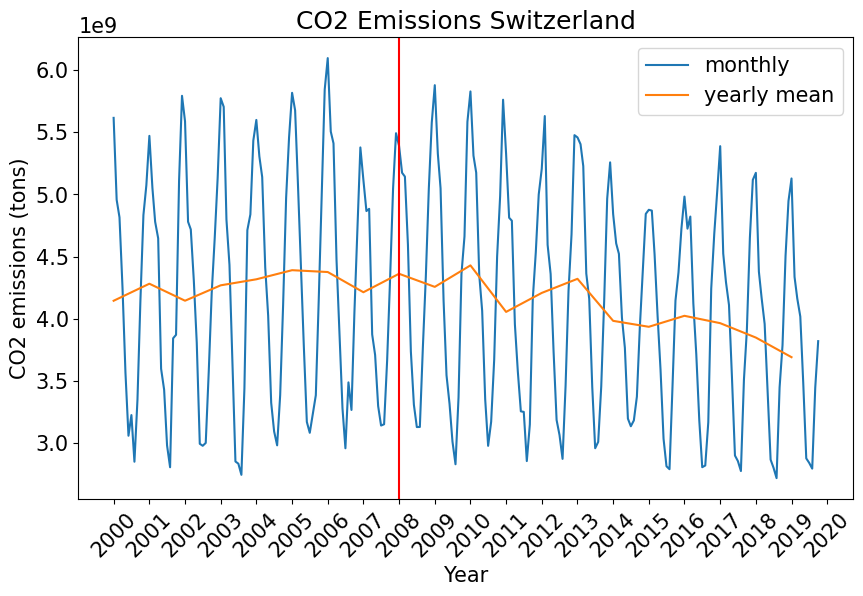

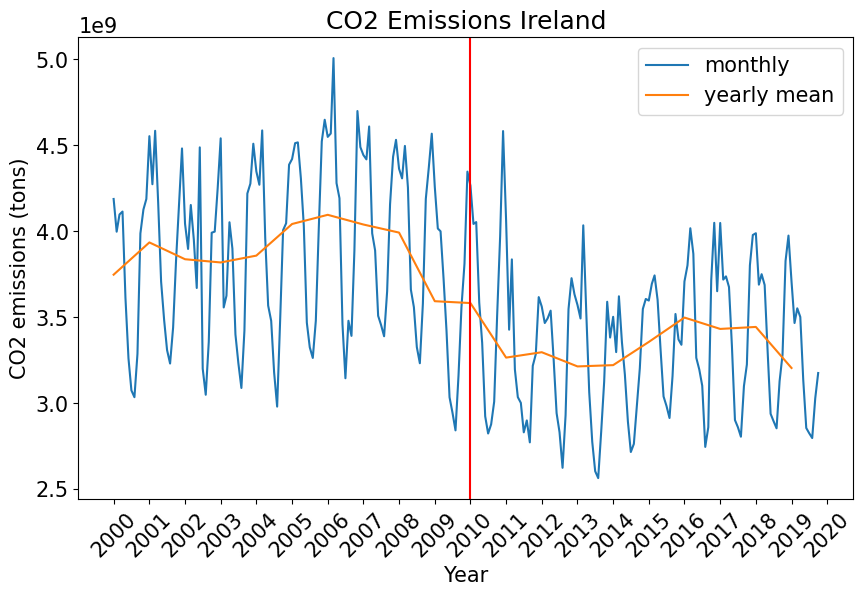

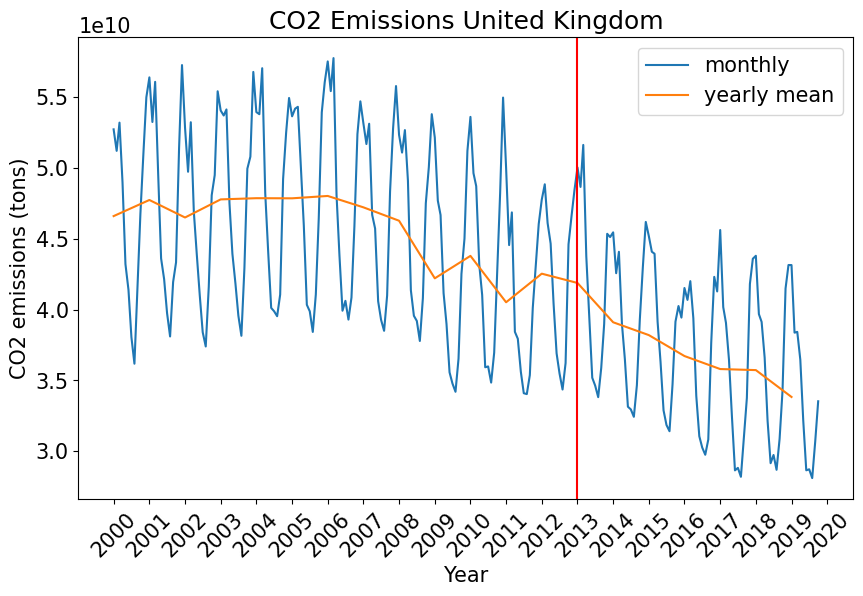

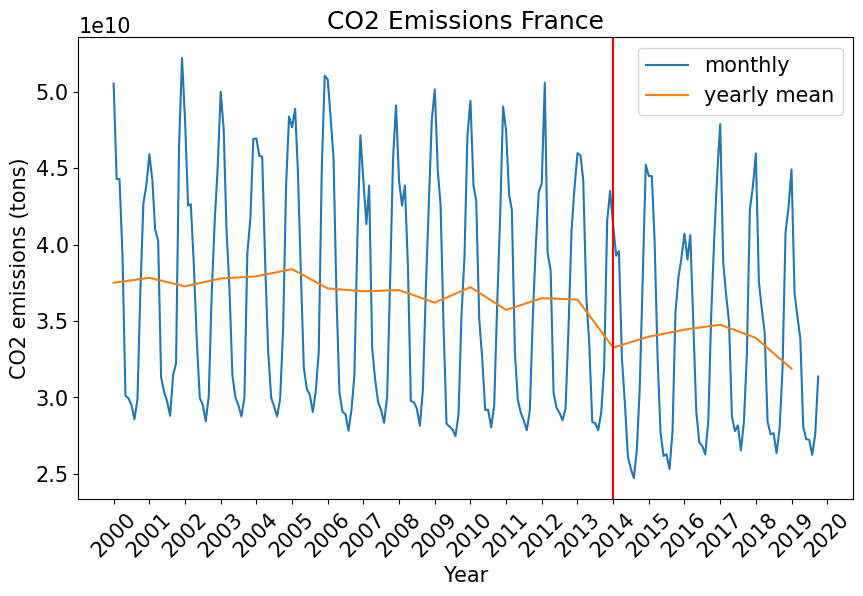

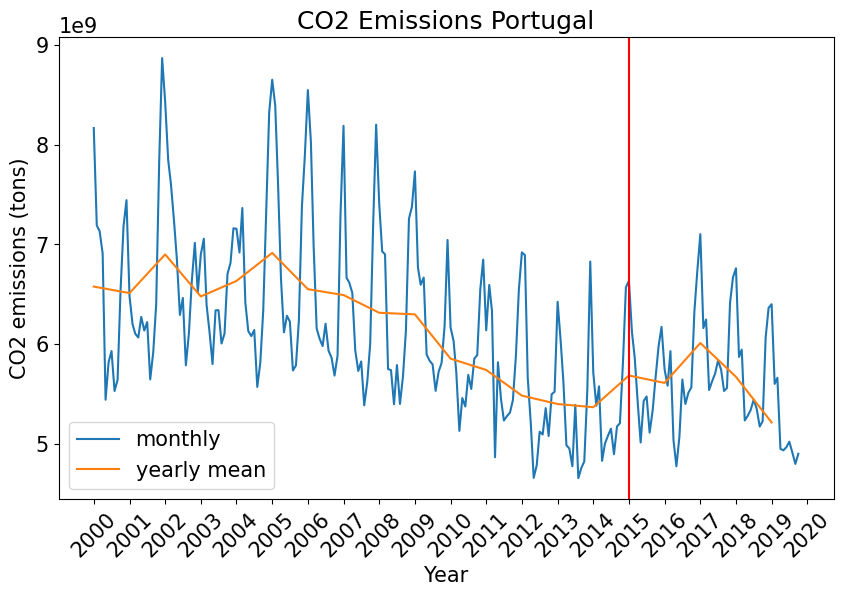

In [33]:
i = 1
for country in target_countries:
    df_country_group = df[df['country']==country][['year', 'co2']].groupby('year').mean()
    df_country_group.index = pd.to_datetime(df_country_group.index, format='%Y')
    
    df_country = df[df['country']==country].set_index('date')['co2']
    df_country.index = pd.to_datetime(df_country.index)
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.plot(df_country, label='monthly')
    ax.plot(df_country_group, label='yearly mean')
    ax.axvline(x=get_impl_date(country, input='dt'), c='red')
    
    ax.xaxis.set_major_locator(mdates.YearLocator())
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        
    ax.set_title(f'CO2 Emissions {country_name_formal[country]}')
    ax.set_xlabel('Year')
    ax.set_ylabel('CO2 emissions (tons)')
    ax.legend()
    
    plt.savefig(f'co2_{country}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    i += 1                 

In [ ]:
# i = 1
# for country in target_countries:
#     df_country = df[df['country']==country][['year', 'co2']].groupby('year').sum()
#     df_country.index = df_country.index.astype(str)
    
#     fig, ax = plt.subplots(figsize=fig_size)
#     ax.plot(df_country)
#     ax.axvline(x=get_impl_date(country)[:4], c='red')

#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)
#     ax.set_title(f'CO2 Emissions {country_name_formal[country]}')
#     ax.set_xlabel('Year')
#     ax.set_ylabel('CO2 emissions (tons)')
    
#     plt.savefig(f'co2_{country}_group.png', dpi=300)
#     plt.show()
    
#     i += 1   

# Stationarity

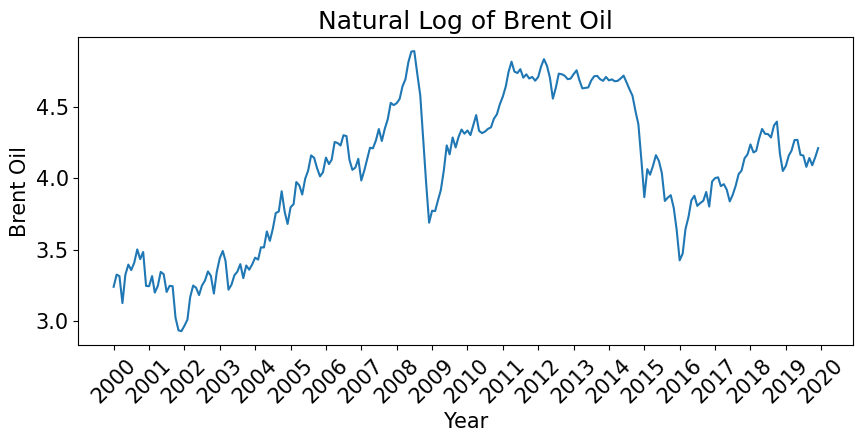

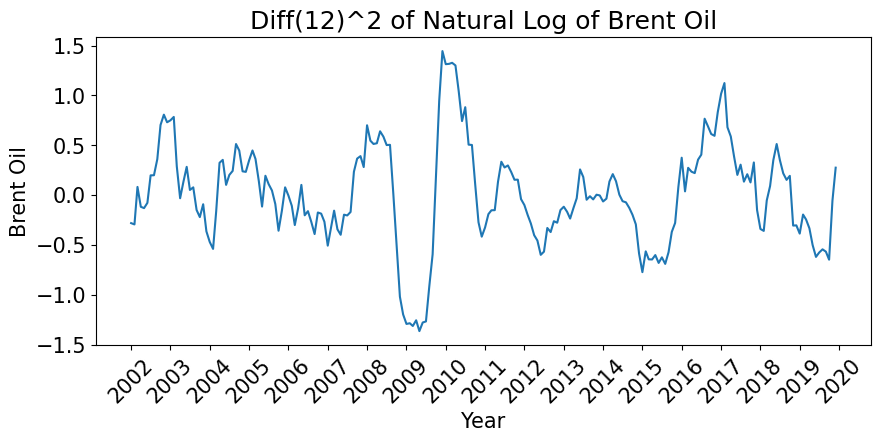

In [78]:
var_name = 'brent'
fig_size = (10, 4)

# log
df_target = np.log(df[df['country']=='france'].set_index('date')[var_name])
df_target.index = pd.to_datetime(df_target.index)

fig, ax = plt.subplots(figsize=fig_size)
ax.plot(df_target)

ax.xaxis.set_major_locator(mdates.YearLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title(f'Natural Log of {var_name_formal[var_name]}')
ax.set_xlabel('Year')
ax.set_ylabel(f'{var_name_formal[var_name]}')

plt.savefig(f'{var_name}_france_log.png', bbox_inches='tight', dpi=300)
plt.show()


# stationary

df_target = np.log(df[df['country']=='france'].set_index('date')[var_name]).diff(12).diff(12)
df_target.index = pd.to_datetime(df_target.index)

fig, ax = plt.subplots(figsize=fig_size)
ax.plot(df_target)

ax.xaxis.set_major_locator(mdates.YearLocator())
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title(f'Diff(12)^2 of Natural Log of {var_name_formal[var_name]}')
ax.set_xlabel('Year')
ax.set_ylabel(f'{var_name_formal[var_name]}')

plt.savefig(f'{var_name}_france_log_diff12.png', bbox_inches='tight', dpi=300)
plt.show()

In [85]:
infl = read_data(get_data_path('m'), 'infl_m')
for country in infl['country'].unique():
    infl_country = infl[infl['country']==country].set_index('date')['infl'].diff(12).dropna()
    stat = 'stationary' if adfuller(infl_country)[1] < 0.05 else '\t non-stationary'
    print(f'{country}: {stat}')

,country,date,year,month,infl
0,austria,2000-01-01,2000,1,0.014
1,austria,2000-02-01,2000,2,0.019
2,austria,2000-03-01,2000,3,0.019
3,austria,2000-04-01,2000,4,0.018
4,austria,2000-05-01,2000,5,0.016
...,...,...,...,...,...
4795,spain,2019-08-01,2019,8,0.004
4796,spain,2019-09-01,2019,9,0.002
4797,spain,2019-10-01,2019,10,0.002
4798,spain,2019-11-01,2019,11,0.005


In [98]:
var_name = 'ind_prod'
df = read_data(get_data_path('m'), f'{var_name}_m')

for country in df['country'].unique():
    df_country = df[df['country']==country].set_index('date')[var_name].diff(12).dropna()
    stat = 'stationary' if adfuller(df_country)[1] < 0.05 else '\t non-stationary'
    print(f'{country}: {stat}')

austria: stationary
belgium: stationary
bulgaria: stationary
croatia: stationary
czech_republic: stationary
france: stationary
germany: stationary
greece: stationary
hungary: stationary
ireland: stationary
italy: stationary
lithuania: stationary
netherlands: stationary
portugal: stationary
romania: stationary
slovakia: stationary
spain: stationary
switzerland: 	 non-stationary
united_kingdom: stationary


# Autocorrelation (ACF & PACF)

In [99]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 
series = df[df['country']=='france'].set_index('date')['co2']
plot_acf(series, lags=24);
plot_pacf(series, lags=24)
plt.show()

KeyError: 'co2'

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# 
series_stat = df_stat[df_stat['country']=='france'].set_index('date')['pop']
plot_acf(series_stat, lags=24);
plot_pacf(series_stat, lags=24)
plt.show()